# Primary-Multiple Curvelet Separation: simple hyperbolas case

For this approach, we apply a multiscale and directional transform to the data and predicted multiples, namely the curvelet transform. With this approach, we can create a mask using the multiples in a sparse and domain and then apply it to the data coefficients, and after that invert them to obtain primaries.

*****

**IMPORTANT!**

You need to install curvelops inside the pylops_37 environment due to this package being compatible only with python 3.7. Please follow the instructions written in the github website: https://github.com/DIG-Kaust/conda_envs/blob/main/install_curvelops.sh

The .yml environment file can be found here:
https://github.com/DIG-Kaust/conda_envs/blob/main/environment_pylops_37.yml

Once complete, run this notebook using pylops_37 env.

*****

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pylops.signalprocessing import FFT2D
from curvelops import FDCT2D
from curvelops.plot import curveshow
from pylops.utils.seismicevents import hyperbolic2d
from pylops.utils.seismicevents import makeaxis
from pylops.utils.wavelets import ricker
from math import ceil, floor
from scipy.signal import filtfilt

import sys
sys.path.append('../adasubtraction/')     # add path to adasubtraction

from curvelet_separation import curvelet_separation

## Separate hyperbolas
For the beginning, we will create hyperbolas with different dips (different velocities in seismic terms) which we'll separate using the curvelet transform.

In [15]:
# Input parameters
par = {
    "ox": 0,
    "dx": 12.5,
    "nx": 300,
    "oy": -500,
    "dy": 10,
    "ny": 101,
    "ot": 0,
    "dt": 0.01,
    "nt": 350,
    "f0": 20
#     "nfmax": 200,
}

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par["f0"])[0]

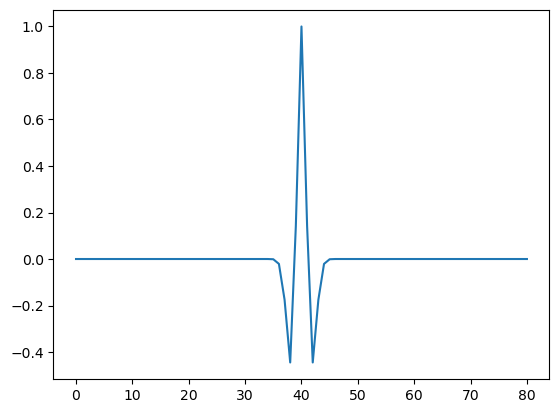

In [16]:
# Plot source wavelet

plt.plot(wav)
plt.show()

Let's call one group of events as "primaries" and the other group as "multiples".

In [17]:
# Primaries input parameters

t_p = np.array((1, 1.5, 2))
vrms_p = np.array((3300.0, 3500.0, 3800.0))
amp_p = np.array((1.1, 1.0, 1.0))

# Generate primaries model
_, b1 = hyperbolic2d(x, t, t_p, vrms_p, amp_p, wav)

# Multiples input parameters

t_m = np.array((0.3, 0.5))
vrms_m = np.array((1500.0, 1100.0))
amp_m = np.array((0.9, 0.9))

# Generate multiples model
_, b2 = hyperbolic2d(x, t, t_m, vrms_m, amp_m, wav)

b = b1 + b2

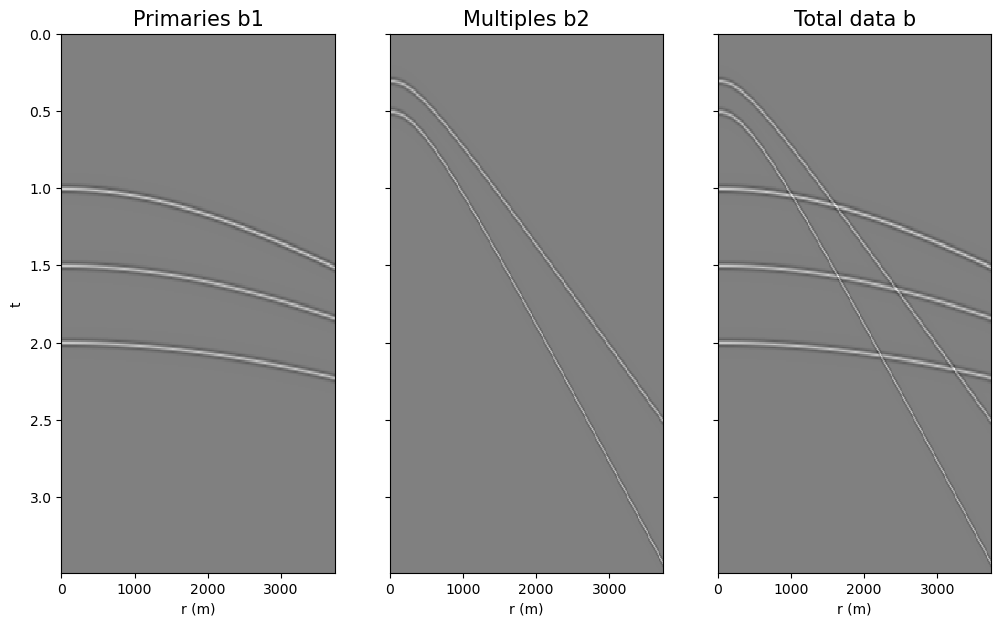

In [18]:
# Plot input

fig, axs = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
axs[0].imshow(
    b1.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[0].set_title(r"Primaries b1", fontsize=15)
axs[0].set_xlabel("r (m)")
axs[0].set_ylabel("t")
axs[1].imshow(
    b2.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[1].set_title(r"Multiples b2", fontsize=15)
axs[1].set_xlabel("r (m)")

axs[2].imshow(
    b.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[2].set_title(r"Total data b", fontsize=15)
axs[2].set_xlabel("r (m)")

plt.show()

Plot the data in the FK Spectrum to check that there is no significant aliasing, and also to see how the dip of the hyperbola relates to the slope of corresponding FK line.

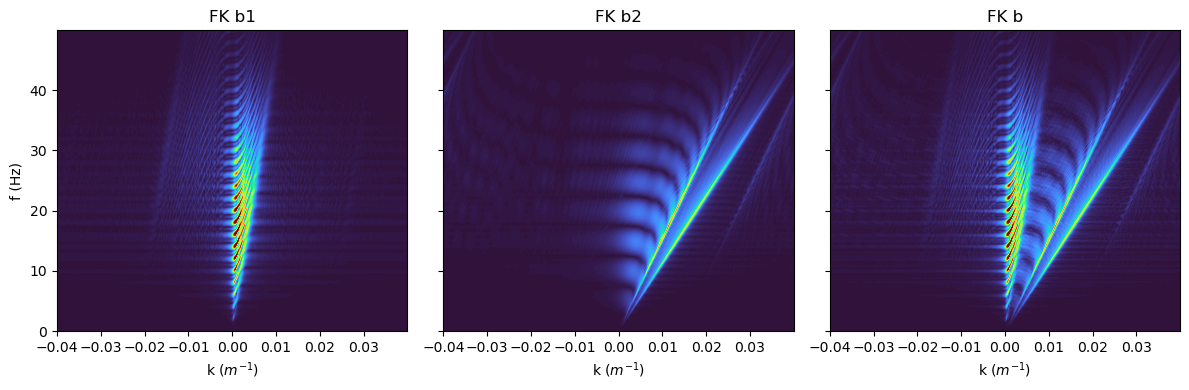

In [19]:
nfft = 2048

# apply 2D Fourier transform
mwav1_fk = np.fft.fft2(b, s=(nfft, nfft))
mwav1_fk = np.fft.fftshift(mwav1_fk, axes=0)

mwav2_fk = np.fft.fft2(b2, s=(nfft, nfft))
mwav2_fk = np.fft.fftshift(mwav2_fk, axes=0)

mwav3_fk = np.fft.fft2(b1, s=(nfft, nfft))
mwav3_fk = np.fft.fftshift(mwav3_fk, axes=0)

# define the axes
f, kx = np.fft.fftfreq(nfft, par['dt']), np.fft.fftfreq(nfft, par['dx'])

vmax_k = 4e2

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12,4))

axs[0].imshow(np.abs(mwav3_fk[:, nfft//2:]).T, aspect='auto', cmap='turbo',
              extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1], f[0], f[nfft//2-1]), vmin=0, vmax=vmax_k);
axs[0].set_title('FK b1')
axs[0].set_xlabel('k ($m^{-1}$)')

axs[0].set_ylabel('f (Hz)')
axs[1].imshow(np.abs(mwav2_fk[:, nfft//2:]).T, aspect='auto', cmap='turbo',
              extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1], f[0], f[nfft//2-1]), vmin=0, vmax=vmax_k);
axs[1].set_title('FK b2')
axs[1].set_xlabel('k ($m^{-1}$)')

axs[2].imshow(np.abs(mwav1_fk[:, nfft//2:]).T, aspect='auto', cmap='turbo',
              extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1], f[0], f[nfft//2-1]), vmin=0, vmax=vmax_k)
axs[2].set_title('FK b')
axs[2].set_xlabel('k ($m^{-1}$)')

plt.tight_layout();

Now we will simulate how the simplest curvelet transform (2 scales and 4 wedges) would segment the FK domain and how the coefficients of each wedge would roughly look like. The following plotting code is taken from Carlos Costas' Curvelops notebook.

In [7]:
F2D = FFT2D(
    b.shape,
    sampling=(par['dx'], par['dt']),
    ifftshift_before=True,
    fftshift_after=True,
    norm="ortho",
    real=False,
)
kx = F2D.f1  # Unit is 1 / (unit of dx)
kt = F2D.f2 # Unit is 1 / (unit of dt)

img_k = F2D @ b

In [8]:
# Create low pass filter for wedge of scale 0

def build_lowpass(kx, kt, scales=2, nsmooth=None):
    if nsmooth is None:
        nsmooth = 0.01 * min(len(kx), len(kt))
        nsmooth = 2 * max(1, floor(nsmooth / 2)) + 1
    mask = np.zeros((len(kx), len(kt)))
    KX, KT = np.meshgrid(kx, kt, indexing="ij")
    kxnyq = np.abs(kx).max()
    ktnyq = np.abs(kt).max()
    inside_scale = (np.abs(KX) < 1/scales * kxnyq) & (np.abs(KT) < 1/scales * ktnyq)
    mask[inside_scale] = 1.0
    s = np.ones((nsmooth,)) / nsmooth
    mask = filtfilt(s, 1, mask, axis=0)
    mask = filtfilt(s, 1, mask, axis=1)
    return mask

lowpass = build_lowpass(kx, kt)
highpass = 1.0 - lowpass

# Now create function to divide the scale 1 in 4 simetric wedges

def build_8wedges_sym(kx, kt, scales=2, wedge=0, nsmooth=None):
    lopass = build_lowpass(kx, kt, nsmooth=nsmooth)
    if nsmooth is None:
        nsmooth = 0.01 * min(len(kx), len(kt))
        nsmooth = 2 * max(1, floor(nsmooth / 2)) + 1

    mask = np.zeros_like(lopass)
    KX, KT = np.meshgrid(kx, kt, indexing="ij")
    kxnyq = np.abs(kx).max()
    ktnyq = np.abs(kt).max()

    s = 1 if wedge == 0 or wedge == 1 else -1
    K1 = KX if wedge == 0 or wedge == 2 else KT
    K2 = KT if wedge == 0 or wedge == 2 else KX
    inside_wedge = (s * (np.abs(K1/np.max(K1)) - np.abs(K2/np.max(K2))) > 0) & (s * KX * KT > 0)
    mask[inside_wedge] = 1
    mask[inside_wedge] -= lopass[inside_wedge]
    s = np.ones((nsmooth,)) / nsmooth
    mask = filtfilt(s, 1, mask, axis=0)
    mask = filtfilt(s, 1, mask, axis=1)
    return mask

wedges = [build_8wedges_sym(kx, kt, wedge=wedge) for wedge in range(4)]

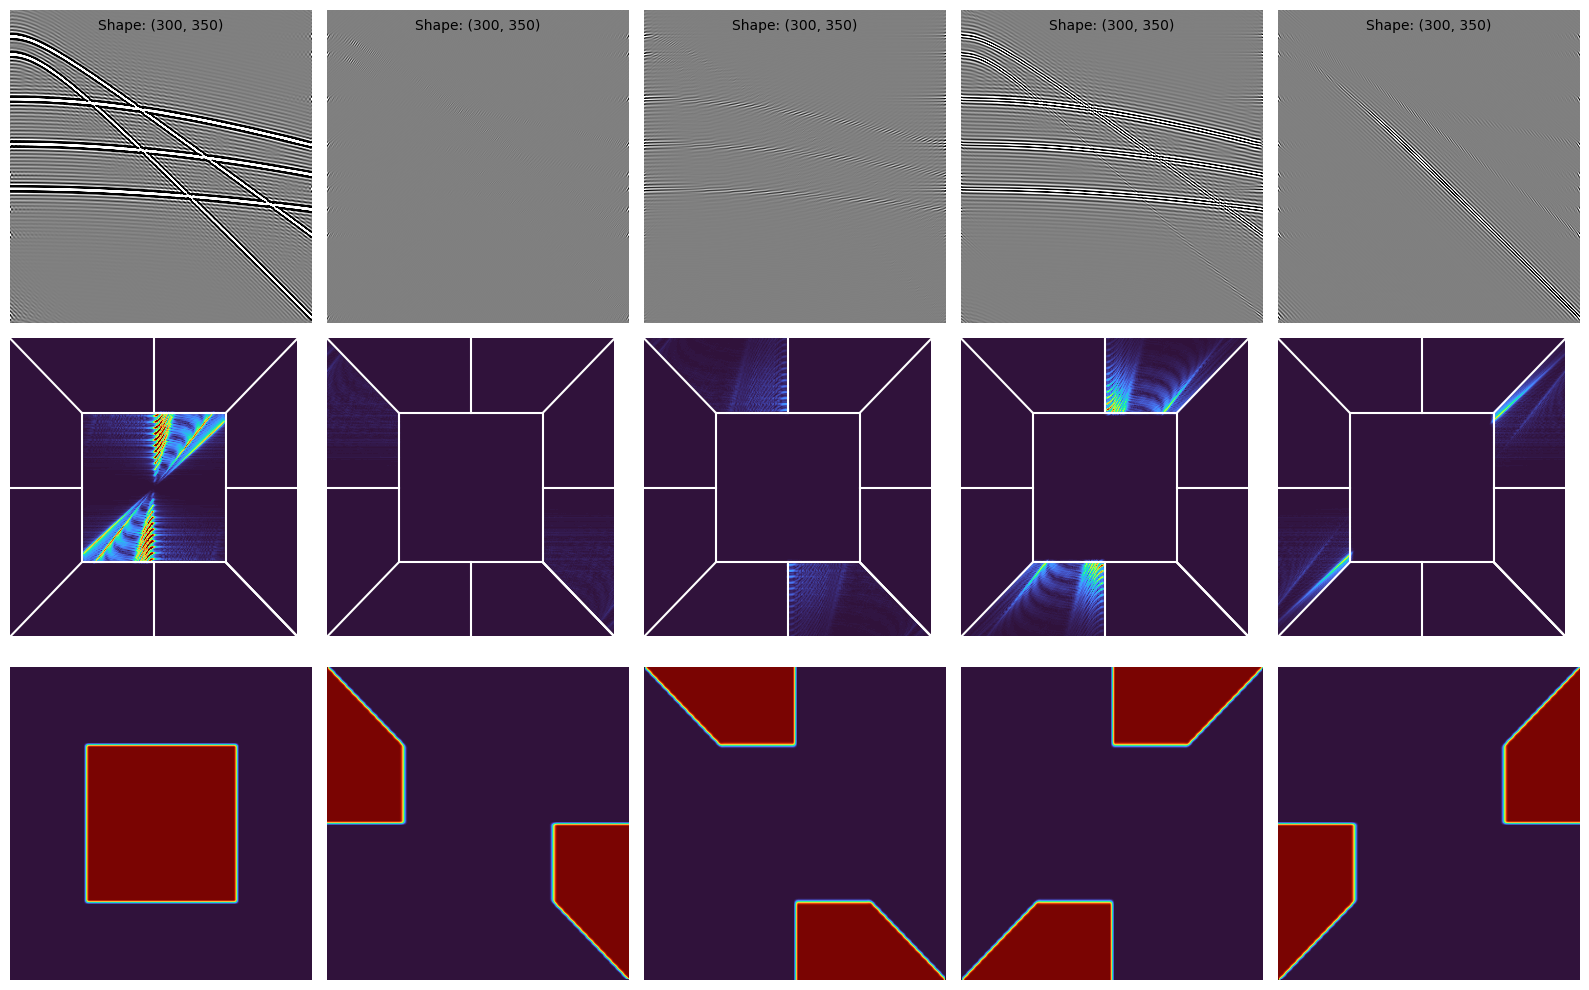

In [9]:
# Plot the results

vmax = 1e-1
vmax_k = 1e0

fig, axes = plt.subplots(3, 5, figsize=(16, 10))
for i, _mask in enumerate(
    [lowpass, *wedges],
):
    _img_k = img_k * _mask
    _img = (F2D.H @ _img_k).real
    axes[0, i].imshow(
        _img.T,
        vmin=-vmax,
        vmax=vmax,
        cmap="gray",
        aspect='auto',
        extent=[x[0], x[-1], t[-1], t[0]],
    )
    axes[0, i].text(
        0.5,
        0.95,
        f"Shape: {_img.shape}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axes[0, i].transAxes,
    )
    axes[1, i].imshow(
        np.abs(_img_k).T,
        vmin=0,
        vmax=vmax_k,
        cmap="turbo",
        aspect='auto',
        extent=[kx[0], kx[-1], kt[-1], kt[0]],
    )
    kxmax = np.abs(kx).max()
    ktmax = np.abs(kt).max()
    axes[1, i].plot(
        0.5 * np.array([-kxmax, kxmax, kxmax, -kxmax, -kxmax]),
        0.5 * np.array([-ktmax, -ktmax, ktmax, ktmax, -ktmax]),
        color="w",
    )
    for s in [1, -1]:
        axes[1, i].plot(
            [s * kxmax, s * 0.5 * kxmax],
            [s * ktmax, s * 0.5 * ktmax],
            color="w",
        )
        axes[1, i].plot(
            [kxmax, 0.5 * kxmax],
            [s * ktmax, s * 0.5 * ktmax],
            color="w",
        )
        axes[1, i].plot(
            [-s * kxmax, -s * 0.5 * kxmax],
            [ktmax, 0.5 * ktmax],
            color="w",
        )
        axes[1, i].plot(
            [0, 0],
            [s * ktmax, s * 0.5 * ktmax],
            color="w",
        )
        axes[1, i].plot(
            [s * kxmax, s * 0.5 * kxmax],
            [0, 0],
            color="w",
        )
    axes[2, i].imshow(
        _mask.T,
        vmin=0,
        cmap="turbo",
        aspect='auto',
        extent=[kx[0], kx[-1], kt[-1], kt[0]],
    )
for ax in axes.ravel():
    ax.axis("off")
# fig.suptitle("Figure 9. Original tetrachromatic signal (leftmost column). Signal separated by \"wedges\"\nin the Fourier domain (center-left to rightmost columns). Rows like Figures 6, 7 and 8.")
fig.tight_layout()

We see that we are able to differentiate events acording to their features (frequency, dip, etc) when we segment the FK domain. We proceed utilizing the Discrete Curvelets Transform Operator (from Curvelops) to transform the data, in order to get a sparser domain where we can easily separate one event from the other.

In [10]:
# Create curvelet transform operator, with 4 scales and 8 wedges in the second scale 

C2D = FDCT2D(b.shape, nbscales=4, nbangles_coarse=8, allcurvelets=True)

b_coefs = C2D.struct(C2D @ b)

# We are dealing with real (not complex) data, so we can use half of the wedges

for iscale in range(len(b_coefs)):
    if len(b_coefs[iscale]) == 1:  # Not a curvelet transform
        print(f"Wedges in scale {iscale+1}: {len(b_coefs[iscale])}")
        continue
    nbangles = len(b_coefs[iscale])
    for iwedge in range(nbangles // 2):
        b_coefs[iscale][iwedge] = (
            b_coefs[iscale][iwedge]  # Wedge
            + b_coefs[iscale][iwedge + nbangles // 2]  # Symmetric counterpart
        ) / np.sqrt(2)
        b_coefs[iscale][iwedge] = ( 
            b_coefs[iscale][iwedge]  # Wedge
            + b_coefs[iscale][iwedge + nbangles // 2]  # Symmetric counterpart
        ) / np.sqrt(2)
    b_coefs[iscale] = b_coefs[iscale][: nbangles // 2]
    print(f"Wedges in scale {iscale+1}: {len(b_coefs[iscale])}")    

Wedges in scale 1: 1
Wedges in scale 2: 4
Wedges in scale 3: 8
Wedges in scale 4: 8


Plot wegdes for each scale.

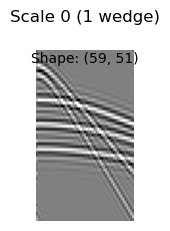

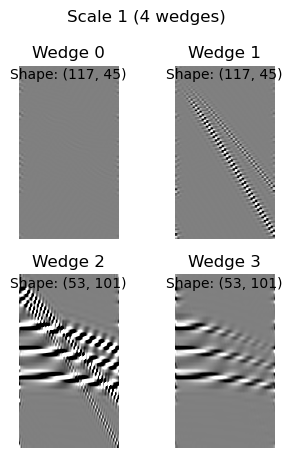

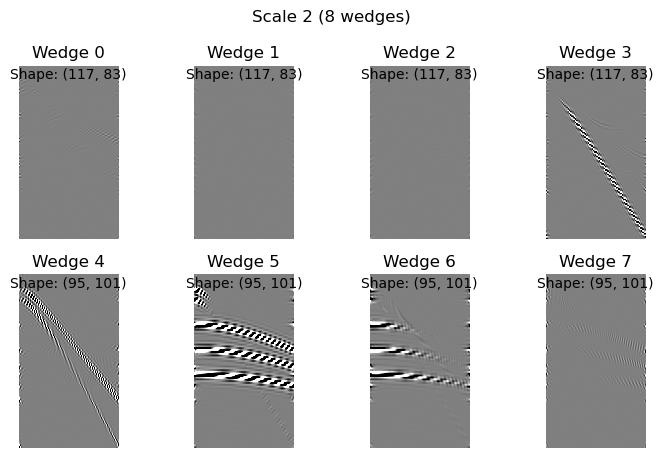

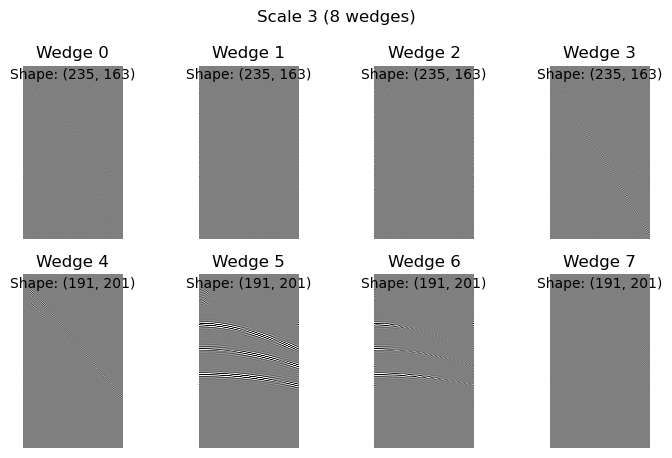

In [11]:
vmax = 0.5*np.max(np.abs(b_coefs[1][3]))
vmin = -vmax

figs_axes = curveshow(
    b_coefs,
    basesize=2,
    kwargs_imshow=dict(vmin=vmin, vmax=vmax, extent=[0, 8, 0, 14])
)
for c_scale, (fig, axes) in zip(b_coefs, figs_axes):
    for iwedge, (c_wedge, ax) in enumerate(
        zip(c_scale, np.atleast_1d(axes).ravel())
    ):
        ax.text(
            0.5,
            0.95,
            f"Shape: {c_wedge.shape}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

### Masking approach

With this approach we select a threshold between 0 and 1, and then create a mask based on the coefficients of the multiples which are greater than this threshold multiplied by the absolute maximum of each wedge. That mask is applied to the data coefficients and then the masked data is converted back to time-space domain. 

In [2]:
# Build masking function

def curvelet_masking(data, multiples, threshold, scales, wedges_num, allcurvelets=False, plot_mask=False):
    
    C2D = FDCT2D(data.shape, nbscales=scales, nbangles_coarse=wedges_num, allcurvelets=allcurvelets)

    mult_coefs = C2D.struct(C2D @ multiples)
    data_coefs = C2D.struct(C2D @ data)

    mask = mult_coefs.copy()
    data_masked_coefs = data_coefs.copy()

    for iscale in range(len(mask)):
        for iwedge in range(len(mask[iscale])):
            condition = np.abs(mult_coefs[iscale][iwedge]) > threshold*np.max(np.abs(mult_coefs[iscale][iwedge]))
            for i in range(condition.shape[0]):
                for j in range(condition.shape[1]):
                    if condition[i][j]:
                        mask[iscale][iwedge][i][j] = 0
                    else:
                        mask[iscale][iwedge][i][j] = 1
            data_masked_coefs[iscale][iwedge] = np.multiply(data_coefs[iscale][iwedge], mask[iscale][iwedge])

    data_masked = np.real(C2D.H @ (C2D.vect(data_masked_coefs)))

    if plot_mask == True:
        
        # Take away repeated wedges
        for iscale in range(len(mask)):
            if len(mask[iscale]) == 1:  # Not a curvelet transform
                continue
            nbangles = len(mask[iscale])
            for iwedge in range(nbangles // 2):
                mask[iscale][iwedge] = (
                    mask[iscale][iwedge]  # Wedge
                    + mask[iscale][iwedge + nbangles // 2]  # Symmetric counterpart
                ) / np.sqrt(2)
                mask[iscale][iwedge] = ( 
                    mask[iscale][iwedge]  # Wedge
                    + mask[iscale][iwedge + nbangles // 2]  # Symmetric counterpart
                ) / np.sqrt(2)
            mask[iscale] = mask[iscale][: nbangles // 2]
            
        # Plot wedges
        vmax = 2
        vmin = -2

        figs_axes = curveshow(
            mask,
            basesize=2,
            kwargs_imshow=dict(vmin=vmin, vmax=vmax, extent=[0, 8, 0, 14])
        )
        for c_scale, (fig, axes) in zip(mask, figs_axes):
            for iwedge, (c_wedge, ax) in enumerate(
                zip(c_scale, np.atleast_1d(axes).ravel())
            ):
                ax.text(
                    0.5,
                    0.95,
                    f"Shape: {c_wedge.shape}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                )

    return data_masked

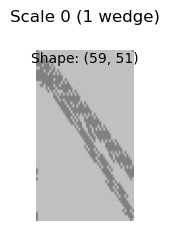

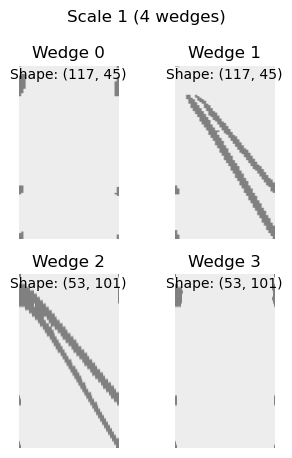

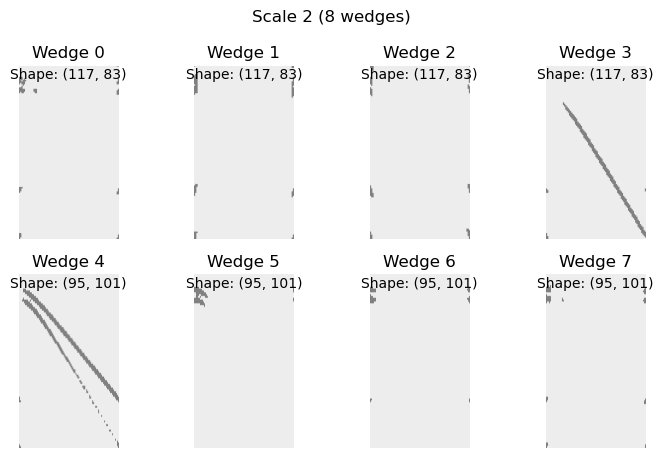

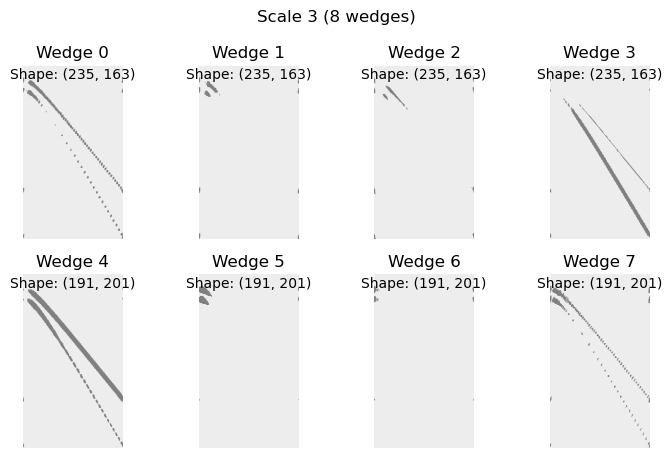

In [13]:
b_mask = curvelet_masking(b, b2, threshold=0.15, scales=4, wedges_num=8, allcurvelets=True, plot_mask=True)

Relative error: 13.4%


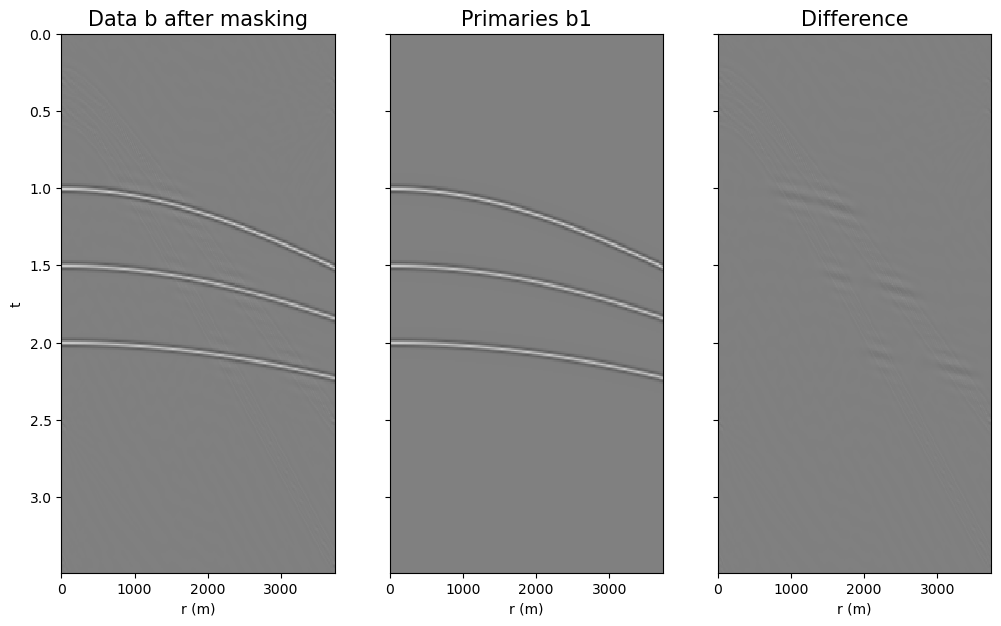

In [14]:
# Plot input

fig, axs = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
axs[0].imshow(
    b_mask.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[0].set_title(r"Data b after masking", fontsize=15)
axs[0].set_xlabel("r (m)")
axs[0].set_ylabel("t")
axs[1].imshow(
    b1.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[1].set_title(r"Primaries b1", fontsize=15)
axs[1].set_xlabel("r (m)")

axs[2].imshow(
    (b_mask-b1).T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[2].set_title(r"Difference", fontsize=15)
axs[2].set_xlabel("r (m)")

print(f'Relative error: {round(np.linalg.norm(b_mask-b1)/np.linalg.norm(b1), 3)*100}%')

plt.show()

Now we will generate a corrupted version of the hyperbolas we want to separate, similar as we would do when we create a multiple model. For that, let's apply a phase shift and scaling and b1 will be the subtraction of b - b2 (corrupted)

In [15]:
def corrupt(data, shift, gain=1):
    
    import numpy as np
    import cmath
    from scipy.fft import rfft, irfft
    
    corr_data = data.copy()

    for r in range(corr_data.shape[0]):

        signal_freq = rfft(corr_data[r])
        shifted_signal_freq = signal_freq*cmath.rect(gain, shift)
        shifted_signal_time = irfft(shifted_signal_freq)
        corr_data[r] = shifted_signal_time 
        
    return corr_data

Relative error: 148.70000000000002%


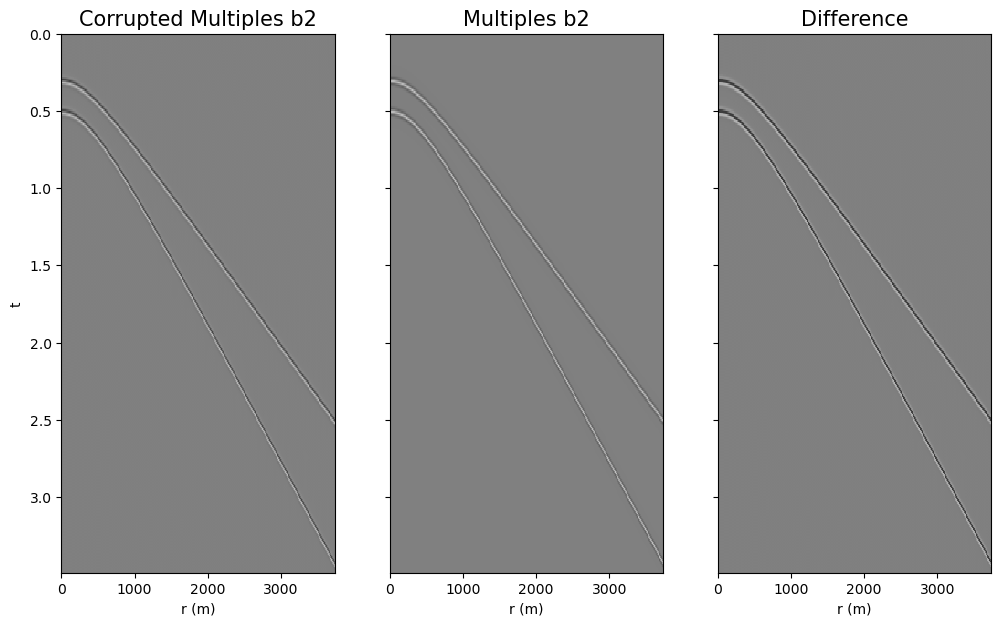

In [16]:
# Corrupt multiples

b2_shift = corrupt(b2, -np.pi/2, gain=1.1)

# Plot corrupted multiples and compare

fig, axs = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
axs[0].imshow(
    b2_shift.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[0].set_title(r"Corrupted Multiples b2", fontsize=15)
axs[0].set_xlabel("r (m)")
axs[0].set_ylabel("t")
axs[1].imshow(
    b2.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[1].set_title(r"Multiples b2", fontsize=15)
axs[1].set_xlabel("r (m)")

axs[2].imshow(
    (b2_shift-b2).T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[2].set_title(r"Difference", fontsize=15)
axs[2].set_xlabel("r (m)")

print(f'Relative error: {round(np.linalg.norm(b2_shift-b2)/np.linalg.norm(b2), 3)*100}%')

plt.show()

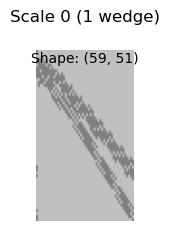

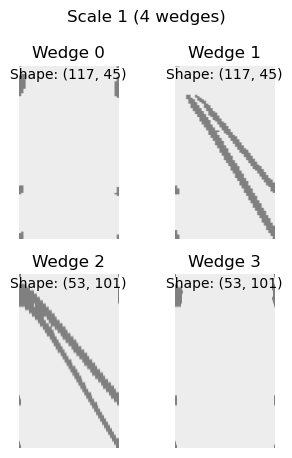

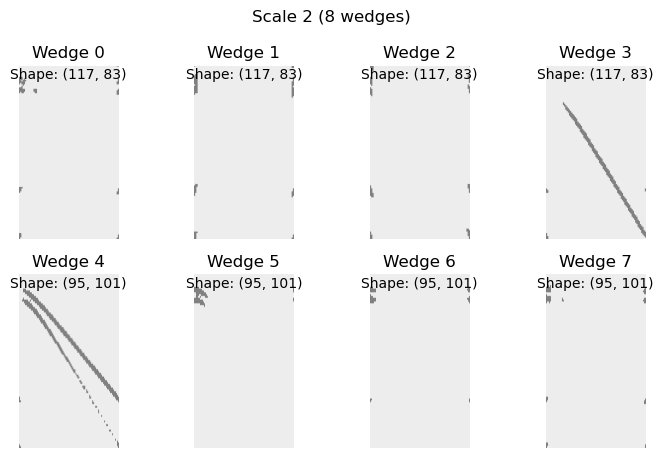

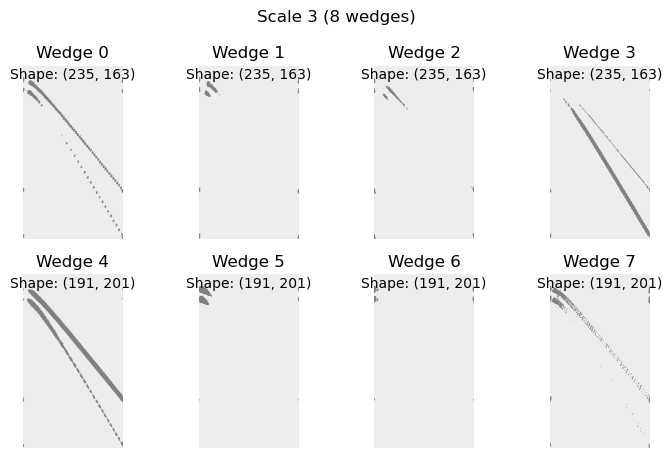

In [17]:
# Put new corrupted input 
b_mask = curvelet_masking(b, b2_shift, threshold=0.15, scales=4, wedges_num=8, allcurvelets=True, plot_mask=True)

Relative error: 13.600000000000001%


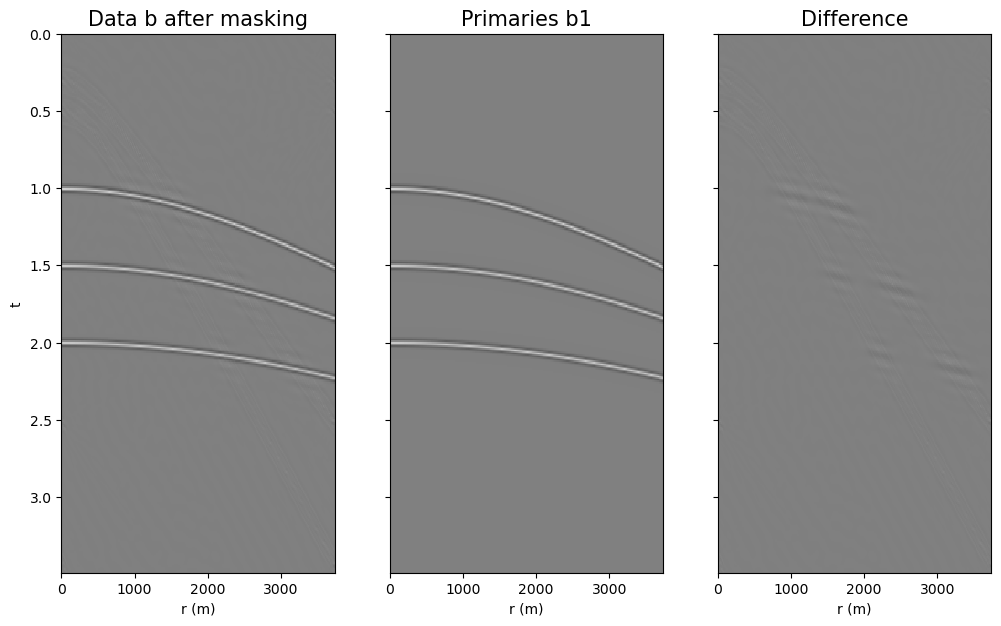

In [20]:
# Plot input

fig, axs = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
axs[0].imshow(
    b_mask.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[0].set_title(r"Data b after masking", fontsize=15)
axs[0].set_xlabel("r (m)")
axs[0].set_ylabel("t")
axs[1].imshow(
    b1.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[1].set_title(r"Primaries b1", fontsize=15)
axs[1].set_xlabel("r (m)")

axs[2].imshow(
    (b_mask-b1).T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[2].set_title(r"Difference", fontsize=15)
axs[2].set_xlabel("r (m)")

print(f'Relative error: {round(np.linalg.norm(b_mask-b1)/np.linalg.norm(b1), 3)*100}%')

plt.show()

We can appreciate an effective removal of the events with higher dip without touching the other events, given that these are found in different wedges, even when we corrupt the input.

### Bayesian Curvelet-Domain Separation Approach
For this approach, the problem is presented as finding the maximum likelihood estimator of the curvelet coefficients of predicted primaries ($b_1$) and predicted multiples ($b_2$), the later obtain from methods such as SRME (Saab et al., 2007). The predicted primaries are obtained by subtracting predicted multiples from total data. We impose weighted L1 norms on the curvelet coefficients of the primaries $x_1$ and multiples $x_2$ ($w_1 = \lambda_1 |Ax_2|$, $w_2 = \lambda_2 |Ax_1|$) and assume white gaussian noise. 

$$ 
P(x_1, x_2|b_1, b_2) = \frac{P(x_1, x_2)P(b_1| x_1, x_2)P(b_2| b_1, x_1, x_2)}{P(b_1, b_2)}
\\
\frac{P(x_1, x_2)P(n)P(n_2)}{P(b_1, b_2)}
$$
maximize posterior probability of exponential distributions
$$
\arg\max_{x_1, x_2} P(x_1, x_2|b_1, b_2) = \arg\max_{x_1, x_2} P(x_1, x_2)P(n)P(n_2)
\\ 
= \arg\max_{x_1, x_2} \exp{\left(-\alpha_1 |x_1|_{1, w_1} - \alpha_2 |x_2|_{1, w_2} - \frac{||Ax_2 - b_2||_2^2}{\sigma_2^2} - \frac{||A(x_1 + x_2) - (b_1 + b_2)||_2^2}{\sigma^2}\right)}
$$
where A is the curvelet synthesis operator. After manipulating the expression above, we arrive to mimizing the function $f(x_1, x_2)$, where
$$
f(x_1, x_2) = \lambda_1 |x_1|_{1, w_1} + \lambda_2 |x_2|_{1, w_2} + ||Ax_2 - b_2||_2^2 + \eta||A(x_1 + x_2) - b||^2_2
$$
This can be solved by iterative soft thresholding (S):
$$
x_1^{n+1} = S_{\frac{w_1}{2\eta}}(A^T b_2 - A^T A x_2^n + A^T b_1 - A^T A x_1^n + x_1^n)
\\
x_2^{n+1} = S_{\frac{w_2}{2(\eta+1)}}\left[A^T b_2 - A^T A x_2^n + x_2^n + \frac{\eta}{\eta+1} (A^T b_1 - A^T A x_1^n)\right]
$$

In [21]:
Cop = FDCT2D(b.shape, nbscales=4, nbangles_coarse=8, allcurvelets=True)

# Input parameters
eps1 = 1.8
eps2 = 0.1
eta = 0.7

# Apply bayes separation algorithm (Saab et al. 2007)
s1 = curvelet_separation(Cop, b, b2_shift, eps1, eps2, eta, niter=20)

Relative error: 10.5%


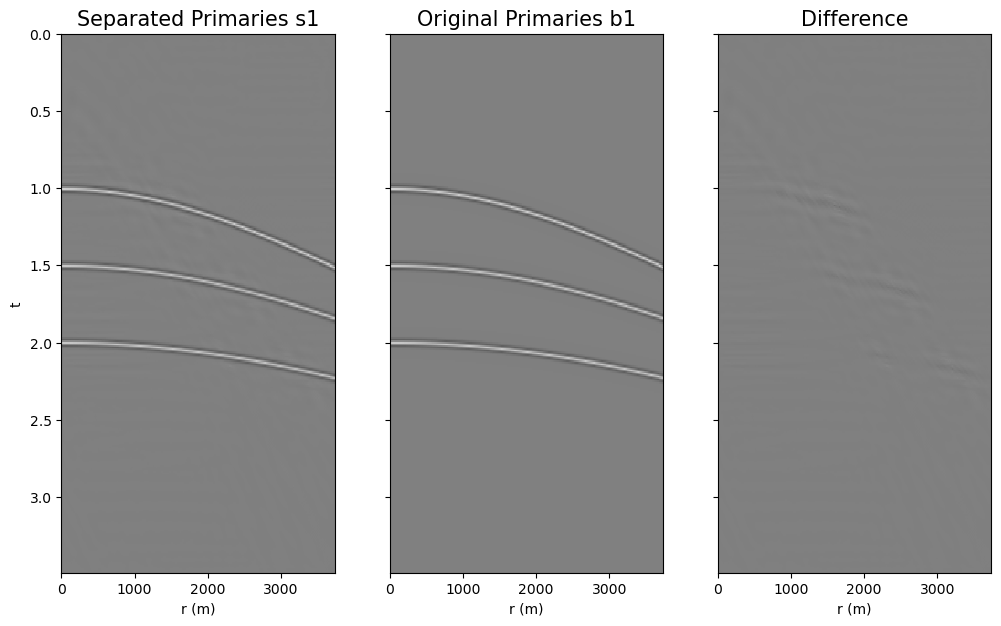

In [22]:
# Plot input

fig, axs = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
axs[0].imshow(
    s1.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[0].set_title(r"Separated Primaries s1", fontsize=15)
axs[0].set_xlabel("r (m)")
axs[0].set_ylabel("t")
axs[1].imshow(
    b1.T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[1].set_title(r"Original Primaries b1", fontsize=15)
axs[1].set_xlabel("r (m)")

axs[2].imshow(
    (s1-b1).T,
    aspect="auto",
    interpolation="nearest",
    cmap="gray",
    vmin=-b.max(),
    vmax=b.max(),
    extent=(x.min(), x.max(), t.max(), t.min()),
)
axs[2].set_title(r"Difference", fontsize=15)
axs[2].set_xlabel("r (m)")

print(f'Relative error: {round(np.linalg.norm(s1-b1)/np.linalg.norm(b1), 3)*100}%')

plt.show()

The background noise is removed more effectively with this approach than with the masking.

### References

Saab R., Wang D., Yilmaz Ö. and Herrmann F. J. (2007). _Curvelet-based primary-multiple separation from a Bayesian perspective_. SEG Technical Program Expanded Abstracts 2007.

Costa, C. (2023). _Desmystifying Curvelets_, Jupyter Notebook, link: https://github.com/PyLops/curvelops/blob/main/notebooks/Desmystifying_Curvelets.ipynb